<a href="https://colab.research.google.com/github/lukes72/Comp5329/blob/main/assignment1__submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP5329 - Deep Learning
## Assignment 1

## Loading the packages

In [ ]:
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
import os.path
%matplotlib inline

 ## The Dataset
Download dataset from google drive

In [ ]:
# load dataset from google drive if data is not loaded
if not os.path.isfile("./Assignment1-Dataset.zip") and not os.path.isfile("./Assignment1-Dataset"):
  !wget --header='Host: drive.usercontent.google.com' --header='User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36' --header='Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7' --header='Accept-Language: en-US,en;q=0.9,vi;q=0.8' --header='Connection: keep-alive' 'https://drive.usercontent.google.com/download?id=14InGdW4cbcSKcxc4YyHBNk4vPzXX4UUN&export=download&authuser=0&confirm=t&uuid=9a6361ee-f799-438d-a146-fbe4bbd84c75&at=APZUnTVAtK9vuqNj8n5ni4b0l54Q%3A1712579283031' -c -O 'Assignment1-Dataset.zip'
  !unzip -o Assignment1-Dataset.zip

In [ ]:
# preprocessing functions

def label_to_one_hot(raw_label):
  # transform labels to one hot
  one_hot = np.zeros(shape = (raw_label.shape[0], 10))
  one_hot[np.arange(raw_label.size), raw_label.flatten()] = 1
  return one_hot

def standardize(data):
  sd = np.std(data, axis = 0)
  mu = np.mean(data, axis = 0)
  return (data - mu)/sd


### Data preprocessing
1.   load dataset google drive
2.   convert dataset label to one hot
3.   standardize the dataset samples



In [ ]:
# load dataset to numpy array
train_X = np.load('./Assignment1-Dataset/train_data.npy', encoding='bytes')
print("train X shape: " + str(train_X.shape))
train_y_raw = np.load('./Assignment1-Dataset/train_label.npy', encoding='bytes')
print("train y shape: " + str(train_y_raw.shape))

test_X = np.load('./Assignment1-Dataset/test_data.npy', encoding='bytes')
print("test_X shape: " + str(test_X.shape))
test_y_raw = np.load('./Assignment1-Dataset//test_label.npy', encoding='bytes')
print("test_y_raw shape: " + str(test_y_raw.shape))

train_y = label_to_one_hot(train_y_raw)
test_y = label_to_one_hot(test_y_raw)

# normalize inputs
train_X = standardize(train_X)
test_X = standardize(test_X)

train X shape: (50000, 128)
train y shape: (50000, 1)
test_X shape: (10000, 128)
test_y_raw shape: (10000, 1)


## Create machine learning structures

### Activation functions



Activation supported here


1.   tanh
2.   logistic
3.   relu
4.   gelu (Advanced operations)
5.   softmax

Note: `__softmax_cross_entropy_deriv` here takes deveritives for not only softmax but also cross entropy, it should only ben used in the output layer





In [ ]:
# create a activation class
# for each time, we can initiale a activation function object with one specific function
# for example: f = Activation("tanh")  means we create a tanh activation function.
# you can define more activation functions by yourself, such as relu!

class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)
        return 1.0 - a**2
    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_deriv(self, a):
        # a = logistic(x)
        return  a * (1 - a )

    def __relu(self, a):
        return np.maximum(0, a)

    def __relu_deriv(self, a):
        a_new = np.copy(a)
        a_new[a_new <= 0] = 0
        a_new[a_new > 0] = 1
        return a_new

    def __gelu(self, x):
        return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))

    def __gelu_deriv(self, x):
        cdf = 0.5 * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))
        pdf = np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)
        return cdf + x * pdf * (1 + np.power(x, 2) * 0.044715) * np.sqrt(2 / np.pi)

    def __softmax(self, x):
        sx = x - np.max(x)
        e_x = np.exp(sx)
        return e_x/np.sum(e_x, axis= x.ndim - 1, keepdims= True)

    def __softmax_cross_entropy_deriv(self, a, y):
      # this function takes the value after activation and the label to return the delta after BOTH softmax AND cross entopy
        return a - y

    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_cross_entropy_deriv
        elif activation == 'gelu':
            self.f = self.__gelu
            self.f_deriv = self.__gelu_deriv

### Define HiddenLayer

This Hidden layer class supports


1.   Forward pass
2.   Backward pass

With functionalities on


1.   Batch normalization
2.   dropout
3.   weight decay
4.   mini-batch gradient decent
5.   Momentum

Which works hand in hand with the MLP class to perform nerual network training/ testing/predicting purposes




In [ ]:
# now we define the hidden layer for the mlp
# for example, h1 = HiddenLayer(10, 5, activation="tanh") means we create a layer with 10 dimension input and 5 dimension output, and using tanh activation function.
# notes: make sure the input size of hiddle layer should be matched with the output size of the previous layer!
class HiddenLayer(object):
    def __init__(self,n_in, n_out,
                 activation_last_layer='tanh',activation='tanh', W=None, b=None, batch_norm_alpha = None, dropout_rate = 0, weight_decay_lambda = 0):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input=None
        self.activation=Activation(activation).f
        self.dropout_rate = dropout_rate
        self.weight_decay_lambda = weight_decay_lambda

        # activation deriv of PREVIOUS layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        # we randomly assign small values for the weights as the initiallization
        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        ).astype(np.float64)

        # we set the size of bias as the size of output dimension
        self.b = np.zeros(n_out,)

        # we set he size of weight gradation as the size of weight
        self.grad_W = np.zeros(self.W.shape).astype(np.float64)
        self.grad_b = np.zeros(self.b.shape).astype(np.float64)

        # Momentum: we initialize momentums, so if we optimize the neural net with momentum we can apply it while update
        self.momentum_W = np.zeros(self.W.shape).astype(np.float64)
        self.momentum_b = np.zeros(self.b.shape).astype(np.float64)

        self.batch_norm = False
        # Batch norm we initialize gamma, beta moving average Mean and Variance
        if batch_norm_alpha is not None:
          self.batch_norm = True
          self.bn_eta = 0.00001
          self.bn_gamma = np.random.uniform(
                low=-np.sqrt(6. / (n_out)),
                high=np.sqrt(6. / (n_out)),
                size= n_out
          ).astype(np.float64)
          self.bn_beta = np.zeros(n_out).astype(np.float64)
          self.bn_moving_mean = np.zeros(n_out).astype(np.float64)
          self.bn_moving_variance = np.zeros(n_out).astype(np.float64)
          self.bn_alpha = batch_norm_alpha



    def forward(self, input, isPredict = False):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        self.input=input

        lin_output = np.dot(input, self.W) + self.b
        # here we apply batch normalization BEFORE the activation
        batch_norm_scaled_input = self.batch_norm_forward(lin_output, isPredict)
        self.output = (
            batch_norm_scaled_input if self.activation is None
            else self.activation(batch_norm_scaled_input)
        )

        # Apply Dropout if training
        if not isPredict and self.dropout_rate > 0:
            self.mask = np.random.binomial(1, 1 - self.dropout_rate, size=self.output.shape)
            self.output *= self.mask / (1 - self.dropout_rate)

        return self.output

    def batch_norm_forward(self, input, isPredict = False):
        if self.batch_norm:
          self.batch_norm_input = input
          # use moving mean & variance if its prediction
          mean = self.bn_moving_mean
          var = self.bn_moving_variance

          if not isPredict:
            # use batch mean & variance for training
            self.current_batch_mean = np.mean(self.batch_norm_input, axis = 0)
            self.current_batch_variance = np.var(self.batch_norm_input, axis = 0)
            mean = self.current_batch_mean
            var = self.current_batch_variance

          # standardize
          self.normalized_intput = (self.batch_norm_input - mean) / np.sqrt(var + self.bn_eta)
          # scale and shift
          return self.bn_gamma * self.normalized_intput + self.bn_beta
        return input

    def batch_norm_backward(self, delta, batch_size):
      # calculate and save gradient of batch norm gamma and beta
      # return the delta propagates beyond batch norm
      if self.batch_norm:
          # calculate dJ/dgamma
          self.grad_bn_gamma = np.mean(self.normalized_intput * delta, axis = 0)
          # calculate dJ/dbeta
          self.grad_bn_beta = np.sum(delta, axis=0) / batch_size

          # calculate delta
          d_norm_input = delta * self.bn_gamma;
          numerator  = (batch_size * d_norm_input) - np.sum(d_norm_input, axis = 0) - (self.normalized_intput * np.sum(d_norm_input * self.normalized_intput, axis = 0))
          denorminator = batch_size * np.sqrt(self.current_batch_variance + self.bn_eta)
          # override delta to the delta pass down from batch norm
          return numerator / denorminator
      return delta


    def backward(self, delta, output_layer=False):
        batch_size = self.input.shape[0]
        delta = self.batch_norm_backward(delta, batch_size)
        self.grad_W = (((np.atleast_2d(self.input)).T.dot(np.atleast_2d(delta))) + self.weight_decay_lambda * self.W) / batch_size
        self.grad_b = np.sum(delta, axis=0) / batch_size
        delta = delta.dot(self.W.T)
        if self.activation_deriv:
            delta = delta * self.activation_deriv(self.input)
        return delta

## The MLP

This MLP class creates multiple layer models according to parameters passed in the constructor. The loss function we use throughout all operations of this class is **cross entropy loss**

It can performer operations on:
1.   fit (train the whole model by forward pass -> backward pass -> update weights)
2.   Validate (predict samples and calculate loss compare to labels)
3.   predict (takes in samples and return prediction)

Which support functionalities of:
1.   Batch normalization
2.   dropout
3.   weight decay
4.   mini-batch gradient decent
5.   Momentum

In [ ]:
class MLP:

    def __init__(self, layers, activation=[None,'tanh','tanh'], batch_norm_alpha = [None, None, None], dropout_rate = [0, 0, 0], weight_decay_lambda = [0, 0, 0]):
        ### initialize layers
        self.layers=[]
        self.params=[]

        self.activation=activation
        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1], batch_norm_alpha=batch_norm_alpha[i + 1], dropout_rate= dropout_rate[i + 1], weight_decay_lambda=weight_decay_lambda[i + 1]))

    # forward progress: pass the information through the layers and out the results of final output layer
    def forward(self,input, isPredict = False):
        for layer in self.layers:
            output=layer.forward(input, isPredict)
            input=output
        return output

    def criterion_cross_entropy(self,y,y_hat):
        loss = -np.mean(np.sum(y * np.log(y_hat), axis = 1))
        delta = Activation("softmax").f_deriv(y_hat, y)
        return loss,delta

    # backward progress
    def backward(self,delta):
        delta=self.layers[-1].backward(delta,output_layer=True)
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta)

    # update the network weights after backward.
    def update(self,lr, lambda_param=0.01, momentum_gamma = None):
        for layer in self.layers:
          if layer.batch_norm:
            # update running mean & variance
            layer.bn_moving_mean = (layer.current_batch_mean * (1 - layer.bn_alpha)) + (layer.bn_alpha * layer.bn_moving_mean)
            layer.bn_moving_variance = (layer.current_batch_variance * (1 - layer.bn_alpha)) + (layer.bn_alpha * layer.bn_moving_variance)
          if momentum_gamma is None:
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b
          else:
            # update momentum of the layer
            layer.momentum_W = (momentum_gamma * layer.momentum_W) + (lr * layer.grad_W)
            layer.momentum_b = (momentum_gamma * layer.momentum_b) + (lr * layer.grad_b)
            # apply momentum to update weights
            layer.W -= layer.momentum_W
            layer.b -= layer.momentum_b

    # define the training function
    # it will return all losses within the whole training process.
    def fit(self,X,y,learning_rate=0.1, epochs=100, momentum_gamma = None, batch_size=1, validation=None):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning

        Return:
        :cross_entropy: if validation is None, we return a 1d np array contains the training loss per epoch
          if validation is not None, we return 2d np array
          which cross_entropy[0] is the training loss per epoch
          cross_entropy[1] is the validation loss per epoch
        """
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(shape=(2, epochs))
        for k in range(epochs):
            loss=np.zeros(X.shape[0]//batch_size) # the losses in each interation
            for it in range(X.shape[0]//batch_size):
                i=np.random.choice(X.shape[0], size=batch_size, replace=False)
                input = X[i]
                # forward pass
                y_hat = self.forward(X[i])
                # backward pass
                loss[it],delta=self.criterion_cross_entropy(y[i],y_hat)
                self.backward(delta)
                # update
                self.update(learning_rate, momentum_gamma)

            to_return[0][k] = np.mean(loss)
            if validation is not None:
              to_return[1][k] = self.validate(validation[0], validation[1])

        if validation is None:
          return to_return[0]
        return to_return

    # define the prediction function
    # we can use predict function to predict the results of new data, by using the well-trained network.
    def predict(self, x):
        x = np.array(x)
        # output = np.zeros(x.shape[0])
        output = []
        for i in np.arange(x.shape[0]):
            output.append(self.forward(x[i,:], isPredict = True))
        return np.array(output)

    def validate(self, x, y):
        pred_y = self.predict(x)
        return self.criterion_cross_entropy(y, pred_y)[0]


### Wrapper function for creating neural net models

The following wrapper function is for simplifing the use of the MLP class to create a neural network model with the specified parameters.

A few notes for this function


1.   When bacth_norm_alpha is None, it means we are not using batch normalization for all layers
2.   when layer_three_size is None, it means we are using a two layer modal.
3.   dropout_rate, batch_norm_alpha, activation applies across all hidden layers



In [ ]:
def buildNN(activation = "relu", batch_norm_alpha = None, layer_one_size = 128, layer_two_size = 128, layer_three_size=None, dropout_rate=0, weight_decay_lambda= 0):
  # this function builds 2 or 3 hidden layers NN only
  hidden_layers = 3 if layer_three_size is not None else 2
  layers_dim = [128, layer_one_size, layer_two_size, 10]
  if hidden_layers == 3:
    layers_dim = [128, layer_one_size, layer_two_size, layer_three_size, 10]

  bn_a = [None] + [batch_norm_alpha] * hidden_layers + [None]
  activations = [None] + [activation] * hidden_layers +['softmax']
  dropout_rates = [0] + [dropout_rate] * hidden_layers + [0]
  weight_decay_lambdas = [0] + [weight_decay_lambda] * hidden_layers + [0]
  return MLP(layers_dim,activations, batch_norm_alpha=bn_a, dropout_rate=dropout_rates, weight_decay_lambda=weight_decay_lambdas)

## Training and Hyperparameter tuning

Prepare dataset for train validation:


1.   Shuffle the dataset
2.   take 20% of the train data as the validation set
3.   take 80% of the train data as the train set



In [ ]:

num_train_samples = train_X.shape[0]
validation_percentage = 0.2
split_size = round(num_train_samples * validation_percentage)

# shuffle train X & Y
def shuffle_x_and_y(X, y):
  np.random.seed(0)
  shuffle_indexes = np.arange(50000)
  np.random.shuffle(shuffle_indexes)
  train_X_shuffled = X[shuffle_indexes]
  train_y_shuffled = y[shuffle_indexes]
  return (train_X_shuffled, train_y_shuffled)
  return (X, y)

train_X_shuffled, train_y_shuffled = shuffle_x_and_y(train_X, train_y)

# train validation split
train_set_X =  train_X_shuffled[split_size:,]
train_set_y =  train_y_shuffled[split_size:,]
validation_set_X =  train_X_shuffled[:split_size,]
validation_set_y =  train_y_shuffled[:split_size,]
validation_set_y =  train_y_shuffled[:split_size,]
print(f"train_set_X.shape: {train_set_X.shape}")
print(f"train_set_y: {train_set_y.shape}")
print(f"validation_set_X: {validation_set_X.shape}")

train_set_X.shape: (40000, 128)
train_set_y: (40000, 10)
validation_set_X: (10000, 128)


### Hyperparameter tuning mechanism

We have grid search and random search for hyperparameter tuning. And we decided to use **random search** for tuning for the report to gain better control of the number of combinations that we want to try.

During the hyperparameter tuning, we are using the train set data(80% of the whole training dataset) for training and the validation set data(remaining 80% of the training dataset) for validation.

We ran 200 random hyperparameter combination(from our parameter grid below) and get our best model by selecting the one with the **least loss** we get from verifying with the **validation data**.

In [ ]:
import random

# train-validation
def validation_loss(activation = "relu", batch_norm_alpha = None, layer_one_size = 128, layer_two_size = 128, layer_three_size=None, learning_rate = 0.1, epochs=20, momentum_gamma = None, batch_size=50, dropout_rate=0, weight_decay_lambda= 0):
  nn = buildNN(activation, batch_norm_alpha, layer_one_size, layer_two_size, layer_three_size, dropout_rate=dropout_rate, weight_decay_lambda=weight_decay_lambda)
  nn.fit(train_set_X, train_set_y, learning_rate, epochs, momentum_gamma, batch_size)
  return nn.validate(validation_set_X, validation_set_y)


def random_search(parameter_grid, num_of_runs = 200):
    best_loss = float("inf")
    best_params = {}
    for i in range(num_of_runs):
        chosen_setting = random.randint(0, len(parameter_grid)-1)
        params = parameter_grid[chosen_setting]
        print(f"Testing params: {params}")

        validation_loss_value = validation_loss(**params)
        print(f"loss: {validation_loss_value}")

        if validation_loss_value < best_loss:
            best_loss = validation_loss_value
            best_params = params

    return best_params, best_loss

def grid_search(parameter_grid):
    best_loss = float("inf")
    best_params = {}

    for params in parameter_grid:
        print(f"Testing params: {params}")
        validation_loss_value = validation_loss(**params)
        print(f"loss: {validation_loss_value}")

        if validation_loss_value < best_loss:
            best_loss = validation_loss_value
            best_params = params

    return best_params, best_loss

Define parameter grid

In [ ]:
parameter_grid = [
    {
        'activation': activation,
        'batch_norm_alpha': batch_norm_alpha,
        'layer_one_size': layer_one_size,
        'layer_two_size': layer_two_size,
        'layer_three_size': layer_three_size,
        'learning_rate': learning_rate,
        'epochs': epochs,
        'momentum_gamma': momentum_gamma,
        'batch_size': batch_size,
        'dropout_rate': dropout_rate,
        'weight_decay_lambda': weight_decay_lambda
    }
    for activation in ['relu', 'gelu']
    for batch_norm_alpha in [None, 0.7, 0.9, 0.99]
    for layer_one_size in [64, 128, 256]
    for layer_two_size in [64, 128, 256]
    for layer_three_size in [None, 64, 128, 256]
    for learning_rate in [ 0.001, 0.01]
    for epochs in [50, 100, 150, 200]
    for momentum_gamma in [None, 0.7]
    for batch_size in [1, 32, 64, 128]
    for dropout_rate in [0.1, 0.3, 0.5]
    for weight_decay_lambda in [0.01, 0.1]
]

Run Hyperparameter tuning with random search

In [ ]:
# # uncomment the following lines to run hyperparameter tuning
# best_params, best_loss = random_search(parameter_grid)
# print(f"Best parameters: {best_params}\nBest validation loss: {best_loss}")

## Define Performance Metrics

`transform_pred_to_onehot` is used for transforming the prediction of our model to one hot code for further metrics evaluation.

`printNNPerformanceMetrics` is used for calculate and printing the


1.   precision
2.   recall
3.   F1 score

on a per class basis and macro basis.

We select **"macro" for the averaging method** because we care about the prediction performance on every classes and wanted to elimate the bias of prediction performance from the unequal distribution of the test set data.



In [ ]:
# Verification helper functions
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
from IPython.display import display

def transform_pred_to_onehot(pred_y_raw):
  pred_y_onehot = np.zeros(shape=pred_y_raw.shape)
  pred_y_onehot_idx = np.argmax(pred_y_raw, axis =1)
  pred_y_onehot[(np.arange(pred_y_onehot.shape[0]),pred_y_onehot_idx)] = 1
  return pred_y_onehot

def printNNPerformanceMetrics(pred_y, test_y):
  pred_y_onehot = transform_pred_to_onehot(pred_y)
  precision = precision_score(test_y, pred_y_onehot, average=None)
  precision_macro = precision_score(test_y, pred_y_onehot, average='macro')

  recall = recall_score(test_y, pred_y_onehot, average=None)
  recall_macro = recall_score(test_y, pred_y_onehot, average='macro')

  f1 = f1_score(test_y, pred_y_onehot, average=None)
  f1_macro = f1_score(test_y, pred_y_onehot, average='macro')

  print("Per class metrics:")
  display(pd.DataFrame(np.array([precision, recall, f1]), np.array(["precision", "recall", "f1-score"]), np.array( [f"class {i}" for i in range(10)])))
  print("Macro-averaged metrics:")
  display(pd.DataFrame(np.array([[precision_macro,recall_macro,f1_macro]]), np.array(["macro-average"]), np.array(["precision", "recall", "f1-score"])))

### Ploting helper function
This is a reusable function for us to plot training and validation/test loss across epochs for Retraining best model and Abletion studies

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_helper(cross_entropy, model_name, loss_names = ["training loss", "validation loss"], benchmark_loss = None, benchmark_loss_name = []):
  pl.figure(figsize=(15,4))
  for i in range(len(loss_names)):
    pl.plot(cross_entropy[i], label=loss_names[i])
  for i in range(len(benchmark_loss_name)):
    pl.plot(benchmark_loss[i], label=benchmark_loss_name[i])
  pl.xlabel("training epochs")
  pl.ylabel("Cross entropy")
  pl.title(model_name + "'s training & validation loss across training epochs")
  pl.legend()
  pl.grid()

def confusion_matrix_plot_helper(y_pred, y_test):
  cm = confusion_matrix(np.argmax(y_pred, axis =1), np.argmax(y_test, axis =1))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()

## Retrain our best model with full training set

After running random search 200 trials on hyperparamater tuning the parameter set gives the lowest cross entropy loss is

`{'activation': 'relu', 'batch_norm_alpha': None, 'layer_one_size': 256, 'layer_two_size': 128, 'layer_three_size': None, 'learning_rate': 0.01, 'epochs': 150, 'momentum_gamma': 0.7, 'batch_size': 64, 'dropout_rate': 0.3, 'weight_decay_lambda': 0.1}`

We now retrain a nerual network model with the same parameters with the full training data(before train-validation split)

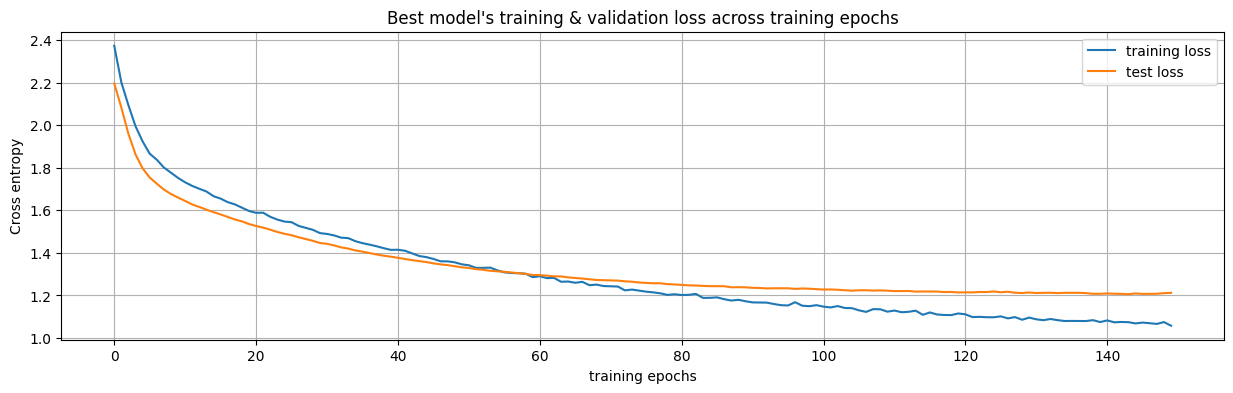

In [ ]:
# Best paramter set: (1.2654350345581782, {'activation': 'relu', 'batch_norm_alpha': None, 'layer_one_size': 256, 'layer_two_size': 128, 'layer_three_size': None, 'learning_rate': 0.01, 'epochs': 150, 'momentum_gamma': 0.7, 'batch_size': 64, 'dropout_rate': 0.3, 'weight_decay_lambda': 0.1})

nn_param = {'activation': 'relu', 'batch_norm_alpha': None, 'layer_one_size': 256, 'layer_two_size': 128, 'layer_three_size': None, 'dropout_rate': 0.3, 'weight_decay_lambda': 0.1}
nn = buildNN(**nn_param)

nn_fit_param = {'learning_rate': 0.01, 'epochs': 150, 'momentum_gamma': 0.7, 'batch_size': 64}
cross_entropy = nn.fit(train_X_shuffled, train_y_shuffled, **nn_fit_param, validation=(test_X, test_y))

plot_helper(cross_entropy, model_name = "Best model", loss_names = ["training loss", "test loss"])
y_pred = nn.predict(test_X)


### Evaluate our best model's performance

Per class metrics:


,class 0,class 1,class 2,class 3,class 4,class 5,class 6,class 7,class 8,class 9
precision,0.655471,0.669331,0.481121,0.417605,0.493659,0.504684,0.589088,0.633072,0.656772,0.579041
recall,0.605000,0.670000,0.395000,0.408000,0.506000,0.431000,0.691000,0.647000,0.708000,0.652000
f1-score,0.629225,0.669665,0.433828,0.412747,0.499753,0.464941,0.635987,0.639960,0.681424,0.613358


Macro-averaged metrics:


,precision,recall,f1-score
macro-average,0.567984,0.5713,0.568089


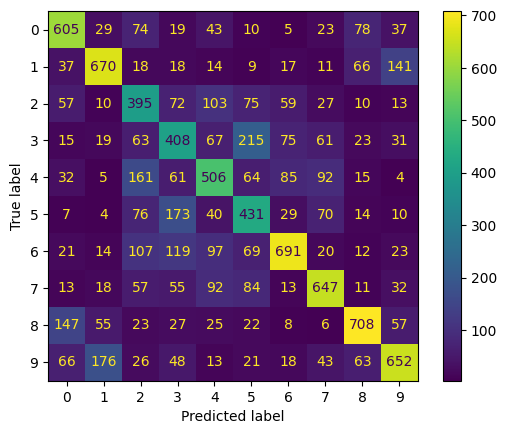

In [ ]:
printNNPerformanceMetrics(y_pred, test_y)
confusion_matrix_plot_helper(y_pred, test_y)

In [ ]:
# export prediction csv
np.savetxt("best_model_predictions.csv", np.argmax(y_pred, axis = 1), delimiter=",")
np.savetxt("best_model_predictions_correctness.csv", np.equal(np.argmax(y_pred, axis = 1), np.argmax(test_y, axis = 1)), delimiter=",")

## Ablation studies

Per class metrics:


,class 0,class 1,class 2,class 3,class 4,class 5,class 6,class 7,class 8,class 9
precision,0.614173,0.686613,0.447881,0.366146,0.486154,0.451813,0.581572,0.601533,0.665081,0.583799
recall,0.624000,0.677000,0.391000,0.305000,0.474000,0.436000,0.688000,0.628000,0.699000,0.627000
f1-score,0.619048,0.681772,0.417512,0.332788,0.480000,0.443766,0.630325,0.614481,0.681619,0.604629


Macro-averaged metrics:


,precision,recall,f1-score
macro-average,0.548477,0.5549,0.550594


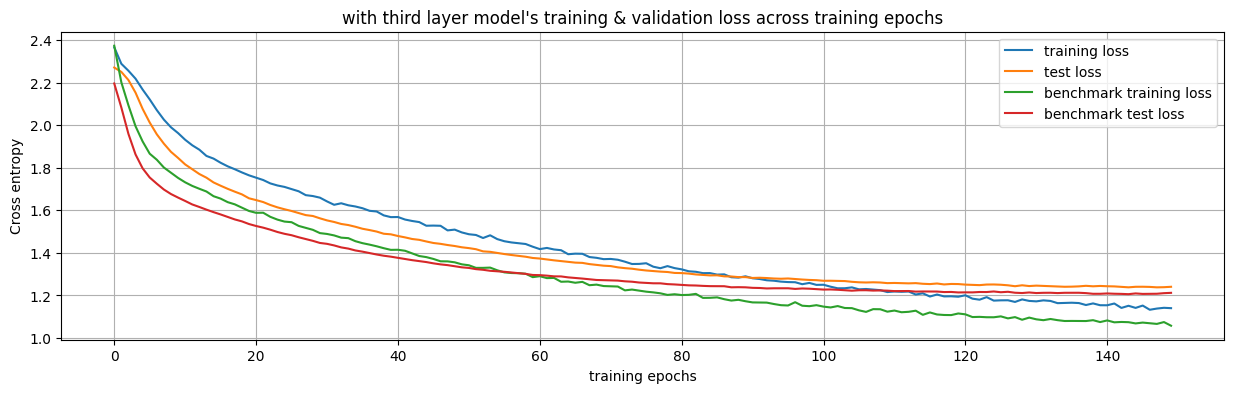

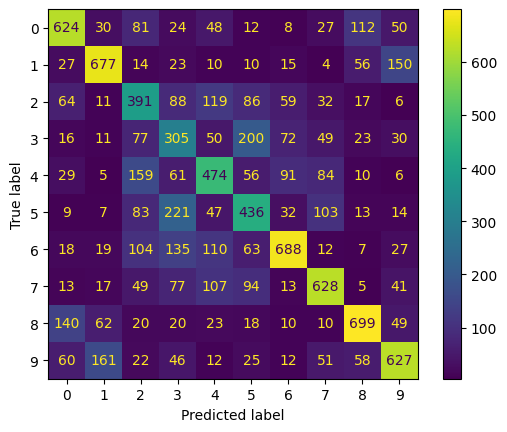

In [ ]:
# # add the thrid layer
# nn_with_third_layer_param = {'activation': 'relu', 'batch_norm_alpha': None, 'layer_one_size': 256, 'layer_two_size': 128, 'layer_three_size': 64, 'dropout_rate': 0.3, 'weight_decay_lambda': 0.1}
# nn_with_third_layer = buildNN(**nn_with_third_layer_param)

# nn_with_third_layer_fit_param = {'learning_rate': 0.01, 'epochs': 150, 'momentum_gamma': 0.7, 'batch_size': 64}
# cross_entropy_with_third_layer = nn_with_third_layer.fit(train_X_shuffled, train_y_shuffled, **nn_with_third_layer_fit_param, validation=(test_X, test_y))

# plot_helper(cross_entropy_with_third_layer, model_name = "with third layer model", loss_names = ["training loss", "test loss"], benchmark_loss = cross_entropy, benchmark_loss_name = ["benchmark training loss", "benchmark test loss"])

# y_pred_with_third_layer = nn_with_third_layer.predict(test_X)
# printNNPerformanceMetrics(y_pred_with_third_layer, test_y)
# confusion_matrix_plot_helper(y_pred_with_third_layer, test_y)

Per class metrics:


,class 0,class 1,class 2,class 3,class 4,class 5,class 6,class 7,class 8,class 9
precision,0.648498,0.71087,0.424395,0.359452,0.500589,0.503788,0.556942,0.629259,0.647112,0.580334
recall,0.583000,0.65400,0.421000,0.367000,0.425000,0.399000,0.714000,0.628000,0.717000,0.661000
f1-score,0.614007,0.68125,0.422691,0.363187,0.459708,0.445313,0.625767,0.628629,0.680266,0.618046


Macro-averaged metrics:


,precision,recall,f1-score
macro-average,0.556124,0.5569,0.553886


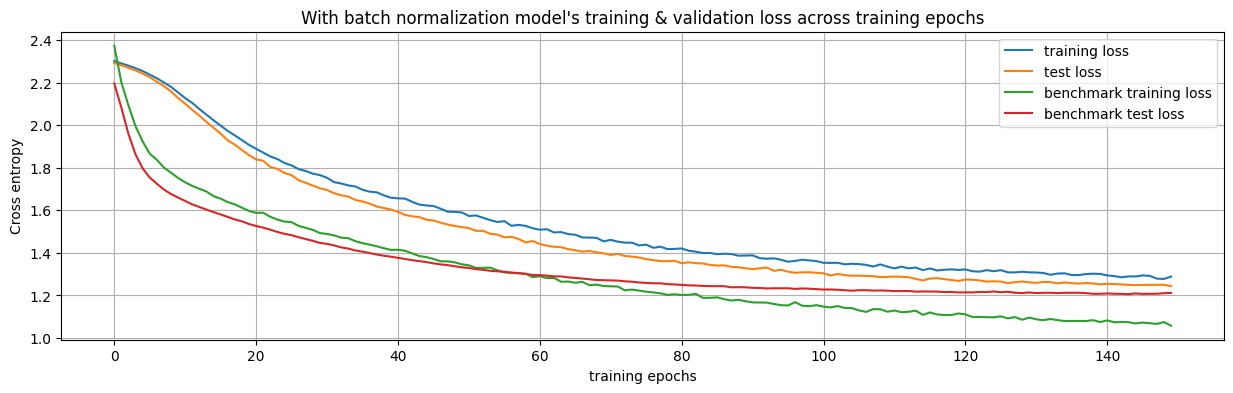

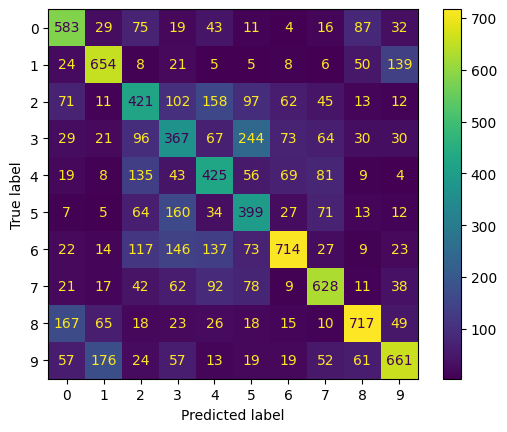

In [ ]:
# # Add batch normalization to all hidden layers
# nn_with_batch_norm_param = {'activation': 'relu', 'batch_norm_alpha': 0.9, 'layer_one_size': 256, 'layer_two_size': 128, 'layer_three_size': None, 'dropout_rate': 0.3, 'weight_decay_lambda': 0.1}
# nn_with_batch_norm = buildNN(**nn_with_batch_norm_param)

# nn_with_batch_norm_fit_param = {'learning_rate': 0.01, 'epochs': 150, 'momentum_gamma': 0.7, 'batch_size': 64}
# cross_entropy_with_batch_norm = nn_with_batch_norm.fit(train_X_shuffled, train_y_shuffled, **nn_with_batch_norm_fit_param, validation=(test_X, test_y))

# plot_helper(cross_entropy_with_batch_norm, model_name = "With batch normalization model", loss_names = ["training loss", "test loss"], benchmark_loss = cross_entropy, benchmark_loss_name = ["benchmark training loss", "benchmark test loss"])

# y_pred_with_batch_norm = nn_with_batch_norm.predict(test_X)
# printNNPerformanceMetrics(y_pred_with_batch_norm, test_y)
# confusion_matrix_plot_helper(y_pred_with_batch_norm, test_y)

Per class metrics:


,class 0,class 1,class 2,class 3,class 4,class 5,class 6,class 7,class 8,class 9
precision,0.548624,0.581395,0.377799,0.337983,0.438251,0.427617,0.551628,0.565217,0.621976,0.542683
recall,0.598000,0.625000,0.388000,0.315000,0.401000,0.384000,0.593000,0.572000,0.617000,0.534000
f1-score,0.572249,0.602410,0.382832,0.326087,0.418799,0.404636,0.571566,0.568588,0.619478,0.538306


Macro-averaged metrics:


,precision,recall,f1-score
macro-average,0.499317,0.5027,0.500495


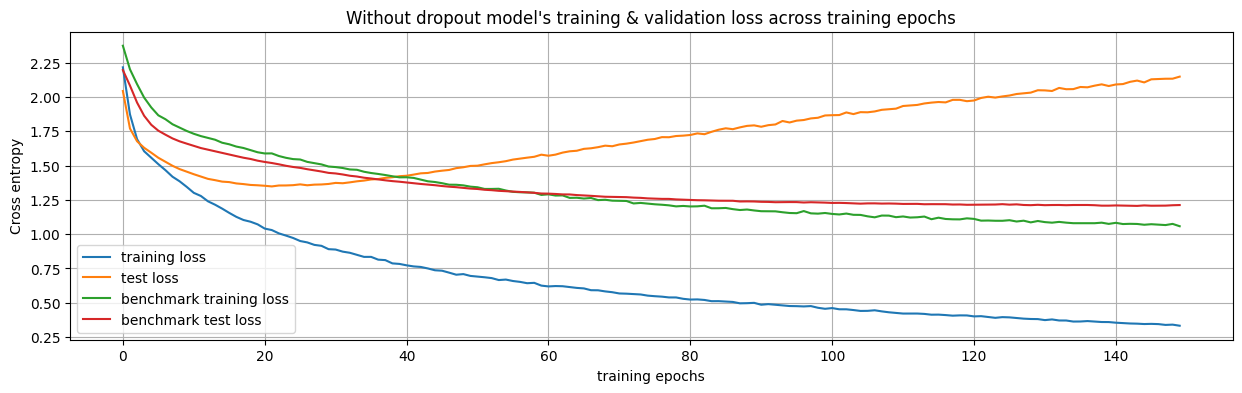

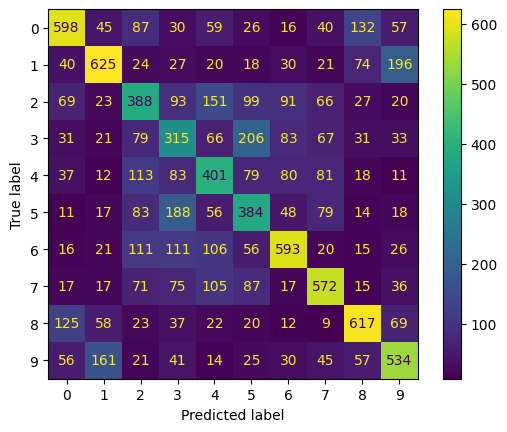

In [ ]:
# # remove dropout
# nn_without_dropout_param = {'activation': 'relu', 'batch_norm_alpha': None, 'layer_one_size': 256, 'layer_two_size': 128, 'layer_three_size': None, 'dropout_rate': 0.0, 'weight_decay_lambda': 0.1}
# nn_without_dropout = buildNN(**nn_without_dropout_param)

# nn_without_dropout_fit_param = {'learning_rate': 0.01, 'epochs': 150, 'momentum_gamma': 0.7, 'batch_size': 64}
# cross_entropy_without_dropout = nn_without_dropout.fit(train_X_shuffled, train_y_shuffled, **nn_without_dropout_fit_param, validation=(test_X, test_y))

# plot_helper(cross_entropy_without_dropout, model_name = "Without dropout model", loss_names = ["training loss", "test loss",], benchmark_loss = cross_entropy, benchmark_loss_name = ["benchmark training loss", "benchmark test loss"])

# y_pred_without_dropout = nn_without_dropout.predict(test_X)
# printNNPerformanceMetrics(y_pred_without_dropout, test_y)
# confusion_matrix_plot_helper(y_pred_without_dropout, test_y)


Per class metrics:


,class 0,class 1,class 2,class 3,class 4,class 5,class 6,class 7,class 8,class 9
precision,0.656481,0.684825,0.478571,0.388889,0.478304,0.469574,0.587682,0.630261,0.672115,0.611538
recall,0.623000,0.704000,0.402000,0.364000,0.485000,0.463000,0.687000,0.629000,0.699000,0.636000
f1-score,0.639302,0.694280,0.436957,0.376033,0.481629,0.466264,0.633472,0.629630,0.685294,0.623529


Macro-averaged metrics:


,precision,recall,f1-score
macro-average,0.565824,0.5692,0.566639


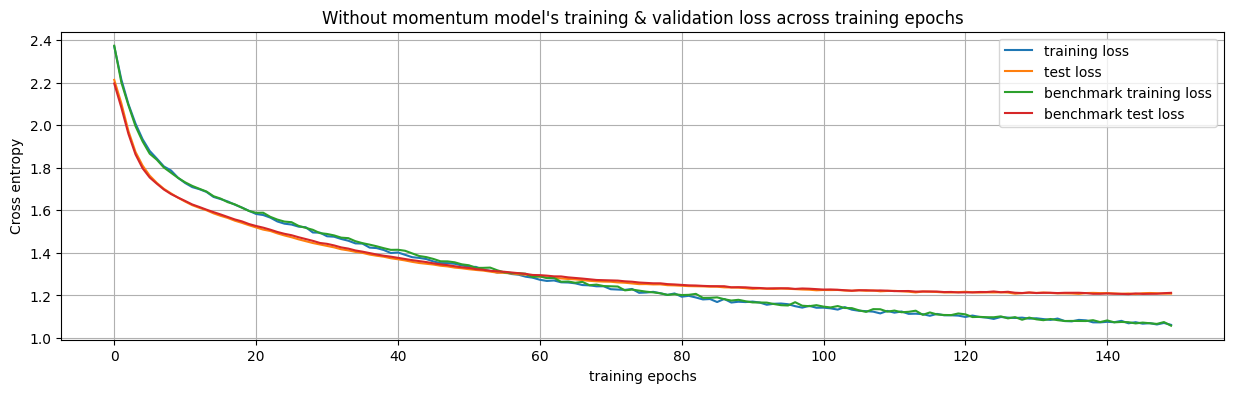

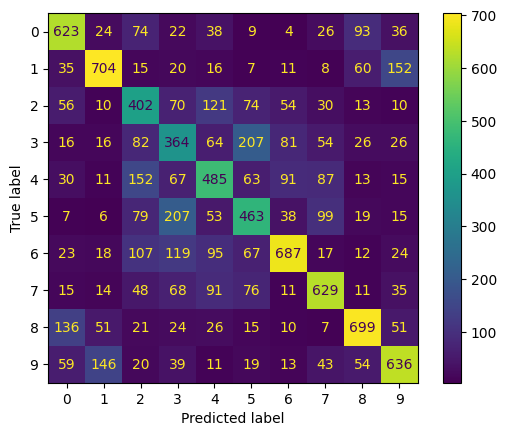

In [ ]:
# # remove momentum
# nn_without_momentum_param = {'activation': 'relu', 'batch_norm_alpha': None, 'layer_one_size': 256, 'layer_two_size': 128, 'layer_three_size': None, 'dropout_rate': 0.3, 'weight_decay_lambda': 0.1}
# nn_without_momentum = buildNN(**nn_without_momentum_param)

# nn_without_momentum_fit_param = {'learning_rate': 0.01, 'epochs': 150, 'momentum_gamma': None, 'batch_size': 64}
# cross_entropy_without_momentum = nn_without_momentum.fit(train_X_shuffled, train_y_shuffled, **nn_without_momentum_fit_param, validation=(test_X, test_y))

# plot_helper(cross_entropy_without_momentum, model_name = "Without momentum model", loss_names = ["training loss", "test loss"], benchmark_loss = cross_entropy, benchmark_loss_name = ["benchmark training loss", "benchmark test loss"])

# y_pred_without_momentum = nn_without_momentum.predict(test_X)
# printNNPerformanceMetrics(y_pred_without_momentum, test_y)
# confusion_matrix_plot_helper(y_pred_without_momentum, test_y)


Per class metrics:


,class 0,class 1,class 2,class 3,class 4,class 5,class 6,class 7,class 8,class 9
precision,0.663746,0.688034,0.450777,0.367619,0.437500,0.513176,0.536683,0.632674,0.642291,0.595517
recall,0.606000,0.644000,0.348000,0.386000,0.539000,0.370000,0.673000,0.608000,0.729000,0.611000
f1-score,0.633560,0.665289,0.392777,0.376585,0.482975,0.429983,0.597161,0.620092,0.682904,0.603159


Macro-averaged metrics:


,precision,recall,f1-score
macro-average,0.552802,0.5514,0.548448


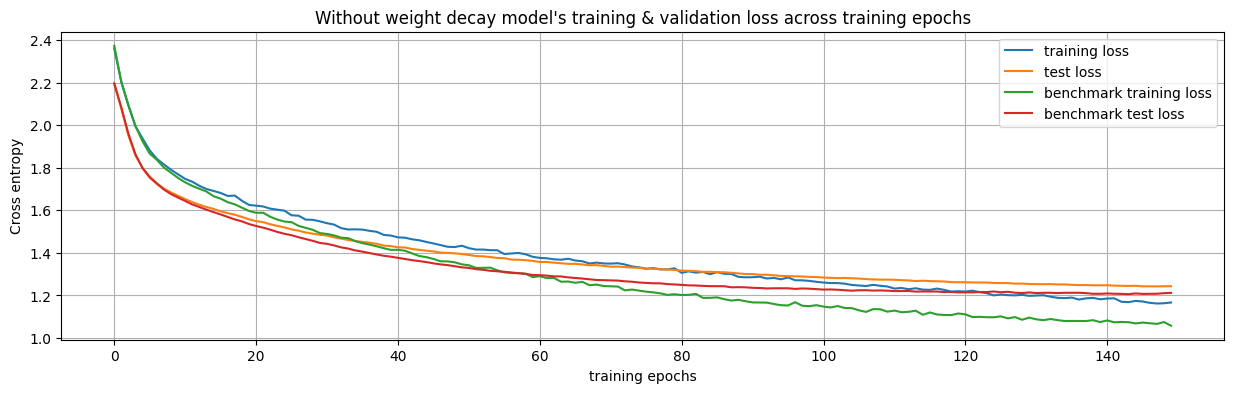

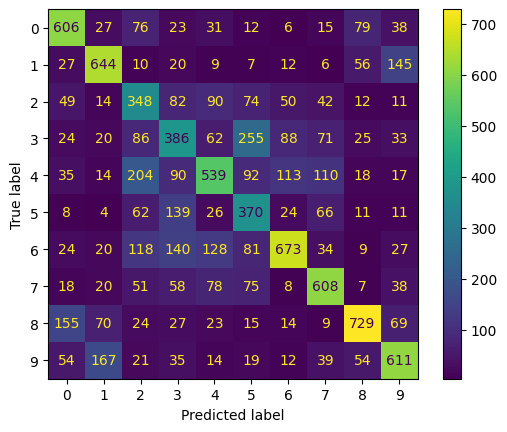

In [ ]:
# # remove weight decay
# nn_without_weight_decay_param = {'activation': 'relu', 'batch_norm_alpha': None, 'layer_one_size': 256, 'layer_two_size': 128, 'layer_three_size': None, 'dropout_rate': 0.3, 'weight_decay_lambda': 0}
# nn_without_weight_decay = buildNN(**nn_without_weight_decay_param)

# nn_without_weight_decay_fit_param = {'learning_rate': 0.01, 'epochs': 150, 'momentum_gamma': 0.7, 'batch_size': 64}
# cross_entropy_without_weight_decay = nn_without_weight_decay.fit(train_X_shuffled, train_y_shuffled, **nn_without_weight_decay_fit_param, validation=(test_X, test_y))

# plot_helper(cross_entropy_without_weight_decay, model_name = "Without weight decay model", loss_names = ["training loss", "test loss"], benchmark_loss = cross_entropy, benchmark_loss_name = ["benchmark training loss", "benchmark test loss"])

# y_pred_without_weight_decay = nn_without_weight_decay.predict(test_X)
# printNNPerformanceMetrics(y_pred_without_weight_decay, test_y)
# confusion_matrix_plot_helper(y_pred_without_weight_decay, test_y)


Per class metrics:


,class 0,class 1,class 2,class 3,class 4,class 5,class 6,class 7,class 8,class 9
precision,0.647236,0.656518,0.462857,0.403455,0.491592,0.483982,0.585304,0.616683,0.704008,0.586998
recall,0.644000,0.690000,0.405000,0.397000,0.497000,0.423000,0.693000,0.621000,0.685000,0.614000
f1-score,0.645614,0.672843,0.432000,0.400202,0.494281,0.451441,0.634615,0.618834,0.694374,0.600196


Macro-averaged metrics:


,precision,recall,f1-score
macro-average,0.563863,0.5669,0.56444


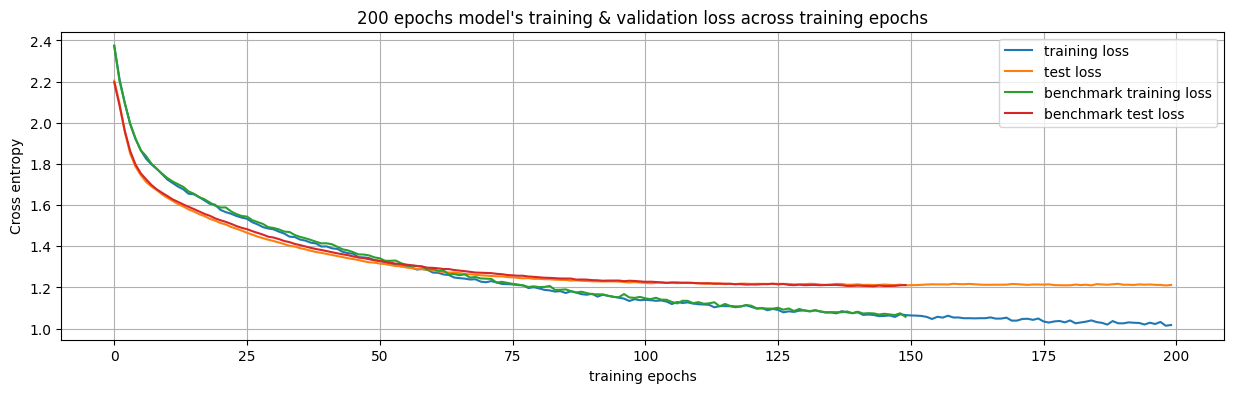

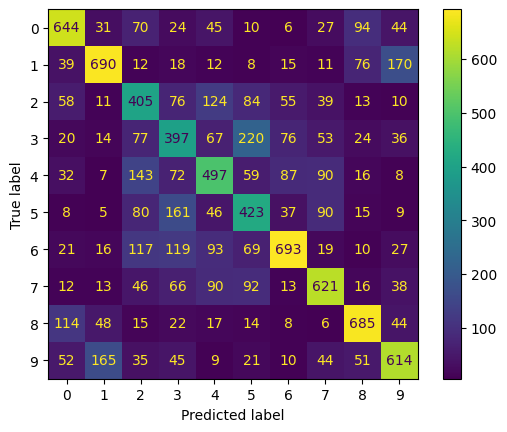

In [ ]:
# # increase epochs to 200
# nn_with_200_epochs_param = {'activation': 'relu', 'batch_norm_alpha': None, 'layer_one_size': 256, 'layer_two_size': 128, 'layer_three_size': None, 'dropout_rate': 0.3, 'weight_decay_lambda': 0.1}
# nn_with_200_epochs = buildNN(**nn_with_200_epochs_param)

# nn_with_200_epochs_fit_param = {'learning_rate': 0.01, 'epochs': 200, 'momentum_gamma': 0.7, 'batch_size': 64}
# cross_entropy_with_200_epochs = nn_with_200_epochs.fit(train_X_shuffled, train_y_shuffled, **nn_with_200_epochs_fit_param, validation=(test_X, test_y))

# plot_helper(cross_entropy_with_200_epochs, model_name = "200 epochs model", loss_names = ["training loss", "test loss"], benchmark_loss = cross_entropy, benchmark_loss_name = ["benchmark training loss", "benchmark test loss"])

# y_pred_with_200_epochs = nn_with_200_epochs.predict(test_X)
# printNNPerformanceMetrics(y_pred_with_200_epochs, test_y)
# confusion_matrix_plot_helper(y_pred_with_200_epochs, test_y)


Per class metrics:


,class 0,class 1,class 2,class 3,class 4,class 5,class 6,class 7,class 8,class 9
precision,0.633788,0.672532,0.451306,0.402597,0.479803,0.472973,0.587927,0.621881,0.643376,0.594569
recall,0.604000,0.688000,0.380000,0.372000,0.487000,0.420000,0.672000,0.648000,0.709000,0.635000
f1-score,0.618536,0.680178,0.412595,0.386694,0.483375,0.444915,0.627158,0.634672,0.674596,0.614120


Macro-averaged metrics:


,precision,recall,f1-score
macro-average,0.556075,0.5615,0.557684


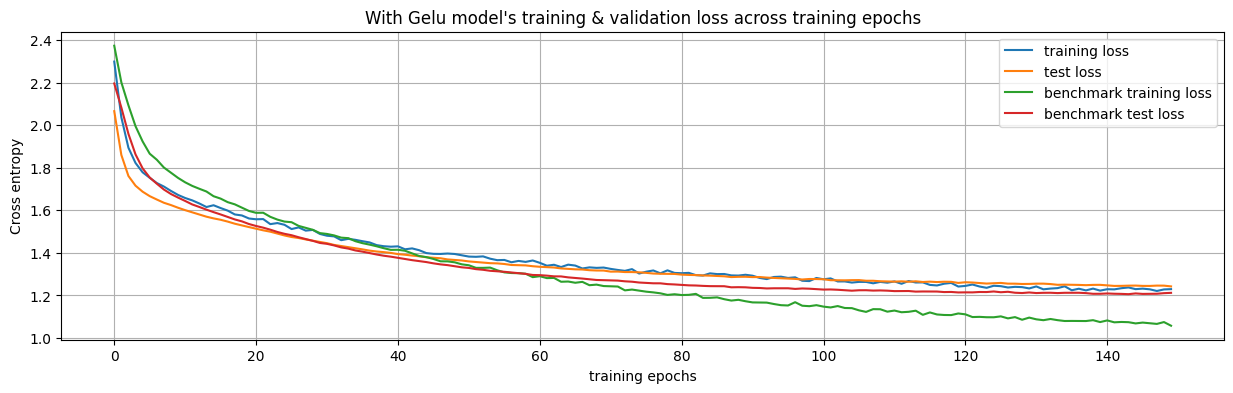

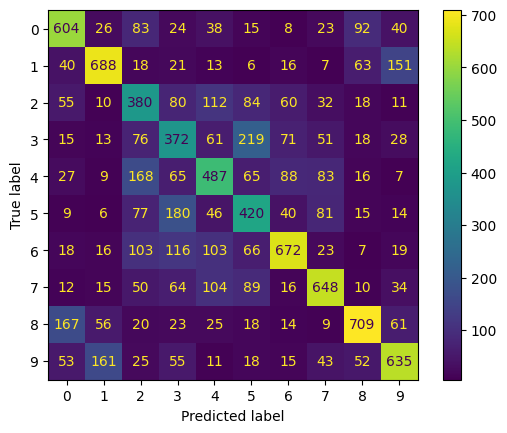

In [ ]:
# # replace relu with gelu
# nn_with_gelu_param = {'activation': 'gelu', 'batch_norm_alpha': None, 'layer_one_size': 256, 'layer_two_size': 128, 'layer_three_size': None, 'dropout_rate': 0.3, 'weight_decay_lambda': 0.1}
# nn_with_gelu = buildNN(**nn_with_gelu_param)

# nn_with_gelu_fit_param = {'learning_rate': 0.01, 'epochs': 150, 'momentum_gamma': 0.7, 'batch_size': 64}
# cross_entropy_with_gelu = nn_with_gelu.fit(train_X_shuffled, train_y_shuffled, **nn_with_gelu_fit_param, validation=(test_X, test_y))

# plot_helper(cross_entropy_with_gelu, model_name = "With Gelu model", loss_names = ["training loss", "test loss"], benchmark_loss = cross_entropy, benchmark_loss_name = ["benchmark training loss", "benchmark test loss"])

# y_pred_with_gelu = nn_with_gelu.predict(test_X)
# printNNPerformanceMetrics(y_pred_with_gelu, test_y)
# confusion_matrix_plot_helper(y_pred_with_gelu, test_y)
